In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd drive/My\ Drive/CSE_237D/experiment_new/experiment_new_new

/content/drive/My Drive/CSE_237D/experiment_new/experiment_new_new


ls: cannot access 'drive/My Drive/CSE_237D/experiment_new/': No such file or directory


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install rasterio
!pip install geopandas

     |████████████████████████████████| 18.2MB 1.1MB/s 
     |████████████████████████████████| 972kB 4.6MB/s 
     |████████████████████████████████| 10.9MB 15.5MB/s 
     |████████████████████████████████| 14.7MB 212kB/s 


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
import os
from yellowbrick.classifier import PrecisionRecallCurve
from PIL import Image
from tqdm import tqdm
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.base import BaseEstimator
from sklearn.semi_supervised import LabelPropagation
from tempfile import TemporaryFile
import matplotlib
matplotlib.use('Agg')
import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import cv2
import glob
import os
from PIL import Image
from tqdm import tqdm
import tensorflow as tf
import subprocess
from sklearn.model_selection import GridSearchCV
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Cropping2D, ELU
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.callbacks import TensorBoard, ModelCheckpoint
import geopandas
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from datetime import datetime
from time import time
import tifffile as tif
from google.colab.patches import cv2_imshow


Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def get_data(image_paths,label_paths,size):
  X = []
  Y = []
  for i,image in tqdm(enumerate(image_paths)):
    img = load_img(image)
    annt = load_img(label_paths[i],color_mode='grayscale')
    img.thumbnail((size, size))
    annt.thumbnail((size, size))
    # Convert to Numpy Array
    x = img_to_array(img) 
    y = img_to_array(annt) 
    x = x.reshape((size,size,3))
    y = y.reshape((size,size,1))
    x = x.astype('float32')
    x /=255.0   #normalize
    y/=255.0    #the labels are now 0,1   (the image has black and white pixels)
    y = y.astype('int32')
    X.append(x)
    Y.append(y)
  return np.asarray(X),np.asarray(Y)

def get_supervised_data(image_paths,label_paths,number_of_supervised_samples,size):
  sup_data_per_class = int(number_of_supervised_samples/2)
  imagepaths = []
  labelpaths = []
  count_mangrove = 0
  count_nonmangrove = 0
  for i,img_path in tqdm(enumerate(image_paths)):
    img = Image.open( label_paths[i] )
    img.load()
    data = np.asarray( img, dtype="int32" )
    #ratio_of_mangroves = float(cv2.countNonZero(img)/65536)
    if 1 in data and count_mangrove <= sup_data_per_class:
      count_mangrove+=1
      imagepaths.append(img_path)
      labelpaths.append(label_paths[i])
    elif count_nonmangrove <= sup_data_per_class:
     count_nonmangrove+=1
     imagepaths.append(img_path)
     labelpaths.append(label_paths[i])
  print("supervised data : ", labelpaths)

  return get_data(imagepaths,labelpaths,size)



'''
Function - This function prepares the data (in numpy array format) 
Input - the path of all available images and annotations, the amout of data to be used for training(value between 0-1), the amount of labelled data(value between 0-1)
Returns -  outfile .npy files containing the numpy datasets
'''
def data_prep(image_paths,label_paths,train_amount,labelled_amount):    
  train_image_paths = image_paths[:int(train_amount * len(image_paths))]
  train_label_paths = label_paths[:int(train_amount * len(image_paths))]
  val_label_paths =  label_paths[int(train_amount * len(image_paths))+1 : ]
  val_image_paths = image_paths[int(train_amount * len(image_paths))+1 : ] 
  test_image_paths = image_paths[:]
  test_label_paths = label_paths[:]
  print("Total data available(tiles of size",size,"x",size,") : ",len(image_paths))
  num_labelled_tiles = int(labelled_amount * len(train_image_paths))
  print("Getting labelled data....")
  x_train, y_train = get_supervised_data (train_image_paths,train_label_paths,num_labelled_tiles,size)
  print("Getting validation data....")
  x_valid, y_valid = get_data(val_image_paths,val_label_paths,size)
  print("Getting test data....")
  x_test, y_test = get_data(test_image_paths,test_label_paths,size)
  print("Getting unlabelled data....")
  x_unlabelled,_ = get_data(train_image_paths,train_label_paths,size)
  print("Shape of labelled data available for training : ", x_train.shape ," and", y_train.shape)
  print("Shape of labelled data available for validation : ", x_valid.shape ," and", y_valid.shape)
  print("Shape of labelled data available for testing : ", x_test.shape ," and", y_test.shape)
  print("Shape of unlabelled data available for training : ", x_unlabelled.shape )
  
  np.save('data_numpy/outfile_x_train90', x_train)  #This folder should exist
  np.save('data_numpy/outfile_y_train90', y_train)
  np.save('data_numpy/outfile_x_valid90', x_valid)
  np.save('data_numpy/outfile_y_valid90', y_valid)
  np.save('data_numpy/outfile_x_test90', x_test)
  np.save('data_numpy/outfile_y_test90', y_test)
  np.save('data_numpy/outfile_x_unlabelled90', x_unlabelled)
  #x_train,y_train,x_valid,y_valid,x_test,y_test,x_unlabelled

  return None


def jaccard_coef(y_true, y_pred, smooth=1e-12):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)

def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 0.65, 0.95):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec))

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
class pseudo_labeller():
  def __init__(self,x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test,label_propagator = False):
    print("*"*100)
    print("*"*100)
    if label_propagator == False:
      print("RUNNING THE PSEUDO LABELLER FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... \n")
    elif label_propagator == True:
      print("RUNNING THE LABEL PROPAGATION MODEL FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... \n")
    self.x_train = x_train
    self.y_train = y_train
    self.x_valid = x_valid
    self.y_valid = y_valid
    self.x_test = x_test
    self.y_test = y_test
    self.x_unlabelled = x_unlabelled
    self.label_propagator = label_propagator

  def data_prep_for_pseudo_labeller(self):
    self.x_train, self.y_train = np.reshape(self.x_train,(self.x_train.shape[0]*self.x_train.shape[1]*self.x_train.shape[2],3)), np.reshape(self.y_train,(self.y_train.shape[0]*self.y_train.shape[1]*self.y_train.shape[2],))
    self.x_valid, self.y_valid = np.reshape(self.x_valid,(self.x_valid.shape[0]*self.x_valid.shape[1]*self.x_valid.shape[2],3)), np.reshape(self.y_valid,(self.y_valid.shape[0]*self.y_valid.shape[1]*self.y_valid.shape[2],))
    self.x_unlabelled = np.reshape(self.x_unlabelled,(self.x_unlabelled.shape[0]*self.x_unlabelled.shape[1]*self.x_unlabelled.shape[2],3))
    return None

  def hyperparamter_tuning(self,classifier):
    #Hyperparameter tuning (doing only for 10% labelled data and then will use same for further experimentation)
    random_grid = {'n_estimators': [5,10,20,30,40],
                  'max_features': ['auto', 'sqrt'],
                  'max_depth': [5,10]}
    
    clf = GridSearchCV(classifier, random_grid)
    clf.fit(self.x_train,self.y_train)
    print(clf.best_params_)
    return None


  def train_pseudo_labeller(self, classifier):
    if self.label_propagator == False:

  
      print("Fitting the ", classifier," classifier..........")
      classifier.fit(self.x_train,self.y_train)
      print("Predicting the labels for the unlabelled pixels....")
      y_unlabelled_pred = classifier.predict(self.x_unlabelled)
      #y_unlabelled_prob = classifier.predict_proba(self.x_unlabelled)
      print("Retraining the model with using the unlabelled data....")
      np.concatenate((self.x_train,self.x_unlabelled))
      np.concatenate((self.y_train,y_unlabelled_pred))
      classifier.fit(self.x_train,self.y_train)
      
      # re-train, labeling unlabeled instances with model predictions, until convergence
      #i = 0
      #unlabeledy_old = []
      #max_iter = 100
      #prob_threshold = 0.7

      #while (len(unlabeledy_old) == 0 or np.any(y_unlabelled_pred != unlabeledy_old)) and i < max_iter:
       # print("Iteration - ", i,"."*50)
       # unlabeledy_old = np.copy(y_unlabelled_pred)
       # uidx = np.where((y_unlabelled_prob[:, 0] > prob_threshold) | (y_unlabelled_prob[:, 1] > prob_threshold))[0]

       # self.x_train = np.vstack(((self.x_train, self.x_unlabelled[uidx, :])))
       # self.y_train = np.hstack((self.y_train, unlabeledy_old[uidx]))
       # classifier.fit(self.x_train,self.y_train )
       # y_unlabelled_pred = classifier.predict(self.x_unlabelled)
       # y_unlabelled_prob = classifier.predict_proba(self.x_unlabelled)
       # i += 1
       # performance_evaluation_pseudo_labeller(classifier)
      return classifier

    elif self.label_propagator == True:
      print("Fitting the ", classifier," classifier..........")
      label_prop_model = LabelPropagation(kernel='knn',n_jobs=-1)
      y_unlabelled= np.full((self.x_unlabelled.shape[0],),-1)
      np.concatenate((self.x_train,self.x_unlabelled))
      np.concatenate((self.y_train,y_unlabelled))
      label_prop_model.fit(self.x_train,self.y_train)
      return label_prop_model
    return None

  def performance_evaluation_pseudo_labeller(self,classifier):
    #print("Pseudo-Labeller score on train data: ",classifier.score(self.x_train, self.y_train), "  IoU: ", jaccard_score(self.y_train, classifier.predict(self.x_train)))
    
    acc = classifier.score(self.x_valid, self.y_valid)
    IoU = jaccard_score(self.y_valid, classifier.predict(self.x_valid))
    #accuracy.append(acc)
    #iou.append(IoU)
    print ("Pseudo-Labeller score on validation data",acc , "  IoU: ",IoU )
    
    %matplotlib inline
    viz = PrecisionRecallCurve(classifier)
    viz.fit(self.x_train,self.y_train)
    viz.score(self.x_valid, self.y_valid)
    viz.show()
   
    return None

  def plot_predictions(self,x_data, y_data, model, img_index=0, CUTOFF=0.5):
    %matplotlib inline
    x = np.reshape(x_data,(x_data.shape[0]*x_data.shape[1]*x_data.shape[2],3))
    predicted_masks = model.predict(x)
    tif.imshow(x_data[img_index, :, :, :])
    tif.imshow(y_data[img_index, :, :, :])
    predicted_masks = np.reshape(predicted_masks, (x_data.shape[0],x_data.shape[1],x_data.shape[2],1))
    tif.imshow(predicted_masks[img_index, :, :, :])
    plt.show()
    return None


In [ ]:
class UNET_Baseline():

  def __init__(self,x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test):
    print("*"*100)
    print("*"*100)
    print("RUNNING THE UNET BASELINE MODEL FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... \n")
    self.x_train = x_train
    self.y_train = y_train
    self.x_valid = x_valid
    self.y_valid = y_valid
    self.x_test = x_test
    self.y_test = y_test
    self.x_unlabelled = x_unlabelled



  def U_Net_Seg_Baseline(self,size,img_shape):
    
    filter_x = size
    filter_by2 = int(size/2)
    filter_by4 = int(size/4)
    filter_by8 = int(size/8)
    filter_into2 = int(size*2)
    inputs = Input(img_shape)
    conv1 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    
    conv1 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    
    conv2 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    
    conv3 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    conv4 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filter_into2, 3, padding='same', kernel_initializer='he_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    
    conv5 = Conv2D(filter_into2, 3, padding='same', kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = Conv2DTranspose(filter_x, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    
    conv6 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = Conv2DTranspose(filter_by2, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    
    conv7 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = Conv2DTranspose(filter_by4, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    
    conv8 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = Conv2DTranspose(filter_by8, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    
    conv9 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(conv9)
    conv9 = BatchNormalization()(conv9) 
    conv9 = ELU()(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, 
                  outputs=conv10)
    return model


  def setup_checkpoint_files(self):
    # # Setup saving of tensorboard files and model checkpoints
    models = []
    time_stamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
    save_file_baseline = 'u-net-baseline-model-{}'.format(time_stamp)

    models.append('final_weights_256/{}.h5'.format(save_file_baseline))
    checkpointer = ModelCheckpoint(models[0], verbose=1, save_best_only=True)

    # Save the log files for tensorboard with a timestamp of the date then the time
    tensorboard_cb = TensorBoard(log_dir='final_logs_256/{}'.format(save_file_baseline))
    return checkpointer, tensorboard_cb

  def model_summary(self, model):
    model.compile(optimizer='adam', 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                                   jaccard_coef, 
                                   mean_iou, 
                                   dice_coef])
    return model.summary()

  def model_train(self,model, checkpointer, tensorboard_cb):
    #fitting the model with the labelled training data
    model.fit(self.x_train, self.y_train, 
                          batch_size=10, 
                          epochs=60, 
                          verbose=1, 
                          shuffle=False, 
                          validation_data=(self.x_valid, self.y_valid),
                          callbacks=[checkpointer, tensorboard_cb])
    return model


  def plot_predictions(self,x_data, y_data, model, img_index=0, CUTOFF=0.5):
    %matplotlib inline
    predicted_masks = model.predict(x_data)
    tif.imshow(x_data[img_index, :, :, :])
    tif.imshow(y_data[img_index, :, :, :])
    tif.imshow(1*(predicted_masks[img_index, :, :, :] > CUTOFF))
    plt.show()
    return None
  

In [ ]:
class UNET_Autoencoder():

  def __init__(self,x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test, x_unlabelled_train, x_unlabelled_valid):
    print("*"*100)
    print("*"*100)
    print("RUNNING THE UNET AUTOENCODER MODEL FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... \n")
    self.x_train = x_train
    self.y_train = y_train
    self.x_valid = x_valid
    self.y_valid = y_valid
    self.x_test = x_test
    self.y_test = y_test
    self.x_unlabelled = x_unlabelled
    #divide the unlabelled images into taining, validation for the autoencoder.
    self.x_unlabelled_train = x_unlabelled_train
    self.x_unlabelled_valid=x_unlabelled_valid
    print("Unlabelled Train Shape: ", self.x_unlabelled_train.shape)
    print("Unlabelled Validation Shape: ", self.x_unlabelled_valid.shape)


  def U_Net_AutoEncoder(self, size, img_shape):
    filter_x = size
    filter_by2 = int(size/2)
    filter_by4 = int(size/4)
    filter_by8 = int(size/8)
    filter_into2 = int(size*2)

    inputs = Input(img_shape)
    conv1 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    
    conv1 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    
    conv2 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    
    conv3 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    
    conv4 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(filter_into2, 3, padding='same', kernel_initializer='he_uniform')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)
    
    conv5 = Conv2D(filter_into2, 3, padding='same', kernel_initializer='he_uniform')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = ELU()(conv5)

    up6 = Conv2DTranspose(filter_x, 2, strides=2, padding='same')(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)
    
    conv6 = Conv2D(filter_x, 3, padding='same', kernel_initializer='he_uniform')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = ELU()(conv6)

    up7 = Conv2DTranspose(filter_by2, 2, strides=2, padding='same')(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)
    
    conv7 = Conv2D(filter_by2, 3, padding='same', kernel_initializer='he_uniform')(conv7)
    conv7 = BatchNormalization()(conv7)
    conv7 = ELU()(conv7)

    up8 = Conv2DTranspose(filter_by4, 2, strides=2, padding='same')(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)
    
    conv8 = Conv2D(filter_by4, 3, padding='same', kernel_initializer='he_uniform')(conv8)
    conv8 = BatchNormalization()(conv8)
    conv8 = ELU()(conv8)

    up9 = Conv2DTranspose(filter_by8, 2, strides=2, padding='same')(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = ELU()(conv9)
    
    conv9 = Conv2D(filter_by8, 3, padding='same', kernel_initializer='he_uniform')(conv9)
    conv9 = BatchNormalization()(conv9) 
    conv9 = ELU()(conv9)
    
    # Note the differences in output layer: 3 channels instead of 1
    conv10 = Conv2D(3, 1, activation='linear')(conv9) 
    
    model = Model(inputs=inputs, 
                  outputs=conv10)

    return model

  def setup_files_autoencoder(self):
    # Setup saving of tensorboard files and model checkpoints
    models = []
    time_stamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
    save_file_ae = 'autoencoder-unsupervised-linear-activ-{}'.format(time_stamp)

    models.append('final_weights_256/{}.h5'.format(save_file_ae))
    checkpointer = ModelCheckpoint(models[0], verbose=1, monitor='val_loss', save_best_only=True)

    # Save the log files for tensorboard with a timestamp of the date then the time
    tensorboard_cb = TensorBoard(log_dir='final_logs_256/{}'.format(save_file_ae))
    return save_file_ae, checkpointer, tensorboard_cb


  def model_summary_ae(self,model):
    model.compile(optimizer=Adam(lr=1e-3), 
                    # Use the MSE loss function for the autoencoder
                    loss='mse', 
                    metrics=['accuracy'])

    return model.summary()

  def model_train_ae(self, model, checkpointer, tensorboard_cb):
    model.fit(self.x_unlabelled_train, self.x_unlabelled_train, 
                  batch_size=32, 
                  epochs=45, 
                  verbose=1, 
                  shuffle=True, 
                  validation_data=(self.x_unlabelled_valid, self.x_unlabelled_valid),
                  callbacks=[checkpointer, tensorboard_cb])
    return model

  '''
  setting up the model to use weights from the autoencoder for fine tuning (semi supervised) 
  '''
  def U_Net_Seg_Transfer(self,base_model, base_model_weights_path):
      
      # Load the weights from the autoencoder 
      base_model.load_weights(base_model_weights_path, by_name=True)
      
      # Get the output of the layer before the last conv layer
      out_base = base_model.layers[-1].output
      
      # Add on the last conv layer for segmentation
      conv_last = Conv2D(1, 1, activation='sigmoid')(out_base)
      
      # Define the inputs and outputs
      model = Model(inputs=base_model.inputs, 
                    outputs=conv_last)

      return model


  def model_summary(self,model):
    model.compile(optimizer=Adam(lr=1e-3), 
                          loss='binary_crossentropy', 
                          metrics=['accuracy', 
                               jaccard_coef, 
                               mean_iou, 
                               dice_coef])
    return model_segmentation.summary()


  def setup_files(self):
    # Setup saving of tensorboard files and model checkpoints
    models = []
    time_stamp = datetime.fromtimestamp(time()).strftime('%Y%m%d-%H%M%S')
    save_file_finetune = 'finetune-unet-alllayers-final{}'.format(time_stamp)

    models.append('final_weights_256/{}.h5'.format(save_file_finetune))
    checkpointer = ModelCheckpoint(models[0], verbose=1, monitor='val_loss', save_best_only=True)

    # Save the log files for tensorboard with a timestamp of the date then the time
    tensorboard_cb = TensorBoard(log_dir='final_logs_256/{}'.format(save_file_finetune))

    return checkpointer,tensorboard_cb

  def model_train(self,model, checkpointer, tensorboard_cb):
    # Train
    model.fit(self.x_train, self.y_train, 
                          batch_size=8, 
                          epochs=65, 
                          verbose=1, 
                          shuffle=False, 
                          validation_data=(self.x_valid, self.y_valid),
                          callbacks=[checkpointer, tensorboard_cb])
    
    return model


  def plot_predictions(self,x_data, y_data, model, img_index=0, CUTOFF=0.5):
    %matplotlib inline
    predicted_masks = model.predict(x_data)
    tif.imshow(x_data[img_index, :, :, :])
    tif.imshow(y_data[img_index, :, :, :])
    tif.imshow(1*(predicted_masks[img_index, :, :, :] > CUTOFF))
    plt.show()
        
    %matplotlib inline
    viz = PrecisionRecallCurve(model)
    viz.fit(self.x_train,self.y_train)
    viz.score(self.x_valid, self.y_valid)
    viz.show()
   
    return None

In [ ]:
size = 256
train_amount = 0.8
labelled_amount = 0.90
images_root = 'dataset_256px/training/images'
labels_root = 'dataset_256px/training/annotations'

In [ ]:



image_paths = glob.glob('dataset_256px/training/images/*.jpg')   #This is random
label_paths = [ img.replace(images_root, labels_root).replace('image','annotation') for img in image_paths  ]

data_prep(image_paths,label_paths,train_amount,labelled_amount)


21it [00:00, 206.62it/s]

Total data available(tiles of size 256 x 256 ) :  2316
Getting labelled data....


1852it [00:04, 459.38it/s]
19it [00:00, 184.29it/s]

supervised data :  ['dataset_256px/training/annotations/annotation_1236.jpg', 'dataset_256px/training/annotations/annotation_1170.jpg', 'dataset_256px/training/annotations/annotation_1197.jpg', 'dataset_256px/training/annotations/annotation_1302.jpg', 'dataset_256px/training/annotations/annotation_1229.jpg', 'dataset_256px/training/annotations/annotation_1187.jpg', 'dataset_256px/training/annotations/annotation_1158.jpg', 'dataset_256px/training/annotations/annotation_1298.jpg', 'dataset_256px/training/annotations/annotation_1108.jpg', 'dataset_256px/training/annotations/annotation_1252.jpg', 'dataset_256px/training/annotations/annotation_989.jpg', 'dataset_256px/training/annotations/annotation_1341.jpg', 'dataset_256px/training/annotations/annotation_1018.jpg', 'dataset_256px/training/annotations/annotation_1250.jpg', 'dataset_256px/training/annotations/annotation_1175.jpg', 'dataset_256px/training/annotations/annotation_1052.jpg', 'dataset_256px/training/annotations/annotation_995.jp

1199it [00:05, 208.80it/s]
22it [00:00, 217.29it/s]

Getting validation data....


463it [00:02, 217.94it/s]
24it [00:00, 230.88it/s]

Getting test data....


2316it [00:10, 220.25it/s]
24it [00:00, 237.70it/s]

Getting unlabelled data....


1852it [00:07, 237.14it/s]


Shape of labelled data available for training :  (1199, 256, 256, 3)  and (1199, 256, 256, 1)
Shape of labelled data available for validation :  (463, 256, 256, 3)  and (463, 256, 256, 1)
Shape of labelled data available for testing :  (2316, 256, 256, 3)  and (2316, 256, 256, 1)
Shape of unlabelled data available for training :  (1852, 256, 256, 3)


In [ ]:
#Load the data

x_train, y_train = np.load('data_numpy/outfile_x_train10.npy'), np.load('data_numpy/outfile_y_train10.npy')
x_valid, y_valid = np.load('data_numpy/outfile_x_valid10.npy'), np.load('data_numpy/outfile_y_valid10.npy')
x_test, y_test = np.load('data_numpy/outfile_x_test10.npy'), np.load('data_numpy/outfile_y_test10.npy')
x_unlabelled = np.load('data_numpy/outfile_x_unlabelled10.npy')



In [ ]:
'''
Clustering based Segmentation
Using all the unlabelled pixels to learn the model and test on the validation sets. 
'''

x_clustering = np.reshape(x_test,(x_test.shape[0]*x_test.shape[1]*x_test[2],3))

****************************************************************************************************
****************************************************************************************************
RUNNING THE PSEUDO LABELLER FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... 

Fitting the  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)  classifier..........
Predicting the labels for the unlabelled pixels....
Retraining the model with using the unlabelled data....
Pseudo-Labeller score on valid

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AttributeError: ignored

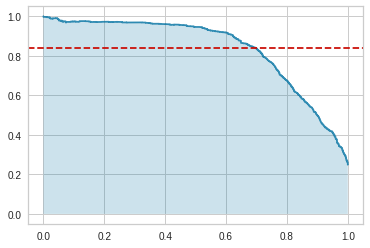

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
'''
THE PSEUDO-LABELLING MODEL
It's a self training model which has a sklearn classifier which trains on the limited labelled training data.
Then this model predicts the unlabelled data and is retrained using both the labelled and unlabelled data.
'''
pseudo_labeller_model = pseudo_labeller(x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test, False)  #False for no label propagation

pseudo_labeller_model.data_prep_for_pseudo_labeller()
#Done Once
#pseudo_labeller_model.hyperparamter_tuning(classifier)

'''
number_trees = [2,5,10,15,20,25,30]
accuracy = []
iou = []
for ntree in number_trees:
  print("For tree number : ", ntree)
  classifier = RandomForestClassifier(max_depth=10,n_estimators=ntree)
  classifier = pseudo_labeller_model.train_pseudo_labeller(classifier)
  pseudo_labeller_model.performance_evaluation_pseudo_labeller(classifier)
  print("*"*100)
  print("*"*100)

#Plot of perfromace eval variation with number of trees
%matplotlib inline
fig = plt.figure()
plt.plot(number_trees, accuracy)
plt.xlabel('number of decision trees')
plt.ylabel('accuracy on validation data')
plt.show()

fig = plt.figure()
plt.plot(number_trees, iou)
plt.xlabel('number of decision trees')
plt.ylabel('IoU on validation data')
plt.show()
'''

classifier = RandomForestClassifier(max_depth=5,n_estimators=10)
classifier = pseudo_labeller_model.train_pseudo_labeller(classifier)
pseudo_labeller_model.performance_evaluation_pseudo_labeller(classifier)
print("*"*100)
print("*"*100)
#PLOT 4 IMAGES for 256 pixels the index of images to plot - 48,49,59,18 , for 4096 the index of images to plot - 1,4,5,8
visualize_image_paths = [os.path.join(images_root,"image_48.jpg"),os.path.join(images_root,"image_49.jpg"),os.path.join(images_root,"image_59.jpg"),os.path.join(images_root,"image_18.jpg")]
visualize_label_paths = [os.path.join(labels_root,"annotation_48.jpg"),os.path.join(labels_root,"annotation_49.jpg"),os.path.join(labels_root,"annotation_59.jpg"),os.path.join(labels_root,"annotation_18.jpg")]
print("Displaying the predictions for some images... \n",visualize_image_paths)
x,y = get_data(visualize_image_paths,visualize_label_paths,size)
for i in range(4):
  pseudo_labeller_model.plot_predictions(x, y, classifier, img_index=i)
 

In [ ]:
'''
LABEL PROPAGATION MODEL   - MEMORY ISSUES
This is a label Propagation model which uses semi supervised module from sklearn to spread labels to unlabelled samples.
All the data points are then used to train a sklearn classifier.
'''
x_graph = x_train[:100]
y_graph = y_train[:100]
x_graph,y_graph = np.reshape(x_graph,(x_graph.shape[0]*x_graph.shape[1],3)), np.reshape(y_graph,(y_graph.shape[0]*y_graph.shape[1],))
print(x_graph.shape,y_graph.shape)
x_train_graph, y_train_graph = x_graph[:int(0.1*x_graph.shape[0])], y_graph[:int(0.1*y_graph.shape[0])]
x_unlabelled_graph= x_graph[int(0.1*x_graph.shape[0])+1:]
label_prop_model = LabelPropagation(kernel='knn',n_jobs=-1)
y_unlabelled_graph= np.full((x_unlabelled_graph.shape[0],),-1)
np.concatenate((x_train_graph,x_unlabelled_graph))
np.concatenate((y_train_graph,y_unlabelled_graph))
label_prop_model.fit(x_train_graph,y_train_graph )
x_graph_valid = x_valid[:100]
y_graph_valid = y_valid[:100]
x_graph_valid,y_graph_valid = np.reshape(x_graph_valid,(x_graph_valid.shape[0]*x_graph_valid.shape[1],3)), np.reshape(y_graph_valid,(y_graph_valid.shape[0]*y_graph_valid.shape[1],1))
acc = label_prop_model.score(x_train_graph, y_train_graph)
IoU = jaccard_score(y_graph_valid, label_prop_model.predict(x_graph_valid), labels=np.unique(label_prop_model.predict(x_graph_valid)))
#accuracy.append(acc)
#iou.append(IoU)
print ("Graph based Label Propagation score on validation data",acc , "  IoU: ",IoU )
'''
label_propagation_model = pseudo_labeller(x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test, True)  #False for no graph based label propagation
classifier = RandomForestClassifier(max_depth=5, n_estimators=10)
label_propagation_model.data_prep_for_pseudo_labeller()
classifier = label_propagation_model.train_pseudo_labeller(classifier)
label_propagation_model.performance_evaluation_pseudo_labeller(classifier)
'''
print("*"*100)
print("*"*100)

(65536, 3) (65536,)
Graph based Label Propagation score on validation data 1.0   IoU:  0.0
****************************************************************************************************
****************************************************************************************************


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


****************************************************************************************************
****************************************************************************************************
RUNNING THE UNET BASELINE MODEL FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... 

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 256, 256, 32) 128         conv2d_21[0][0]                  
__

4it [00:00, 200.47it/s]

Displaying the predictions for some images... 
 ['dataset_256px/training/images/image_48.jpg', 'dataset_256px/training/images/image_49.jpg', 'dataset_256px/training/images/image_59.jpg', 'dataset_256px/training/images/image_18.jpg']


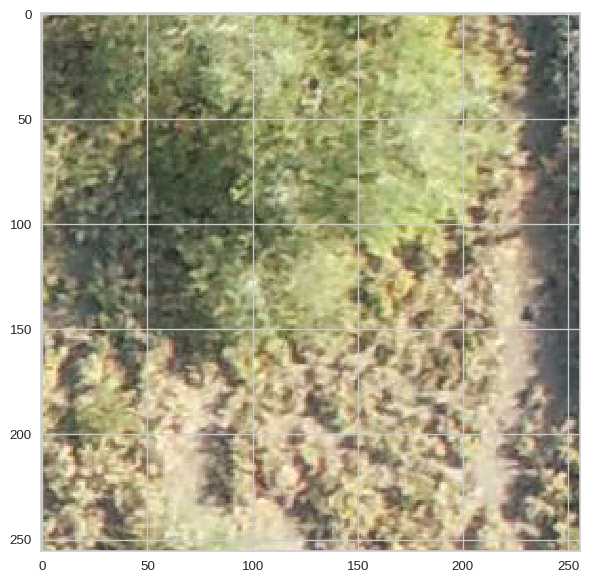

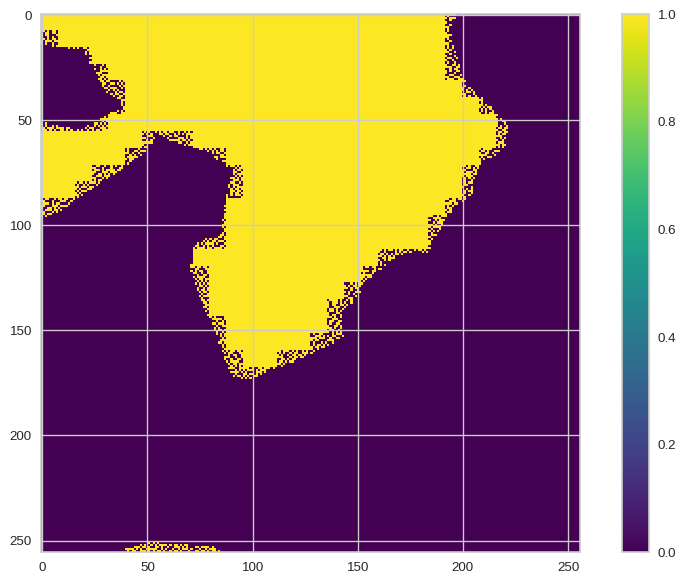

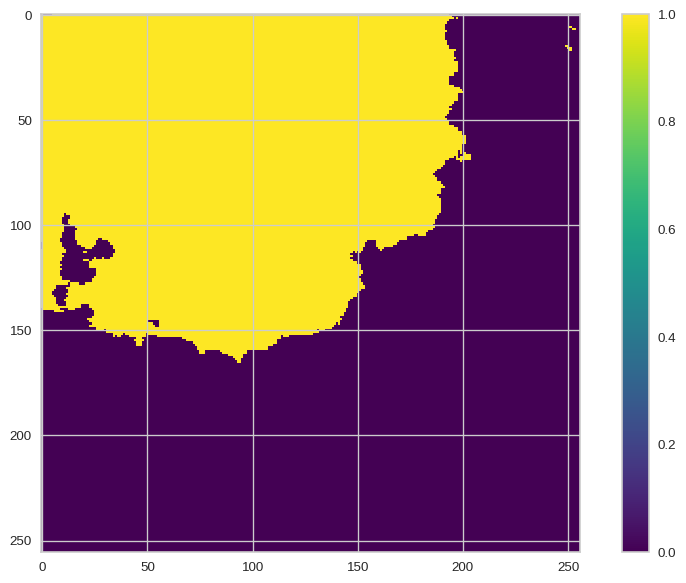

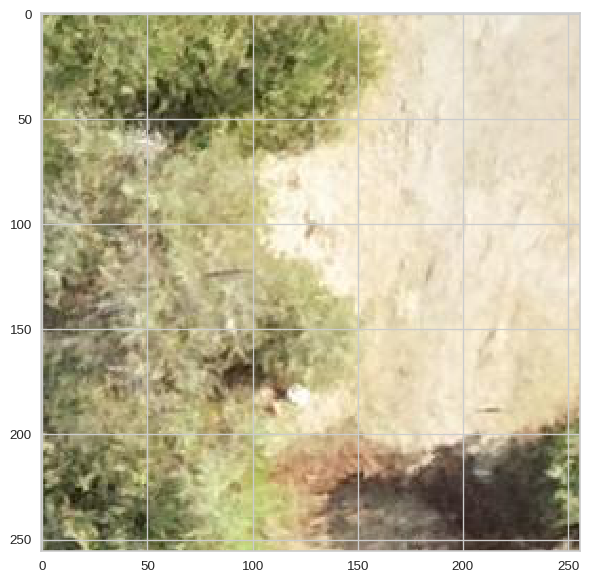

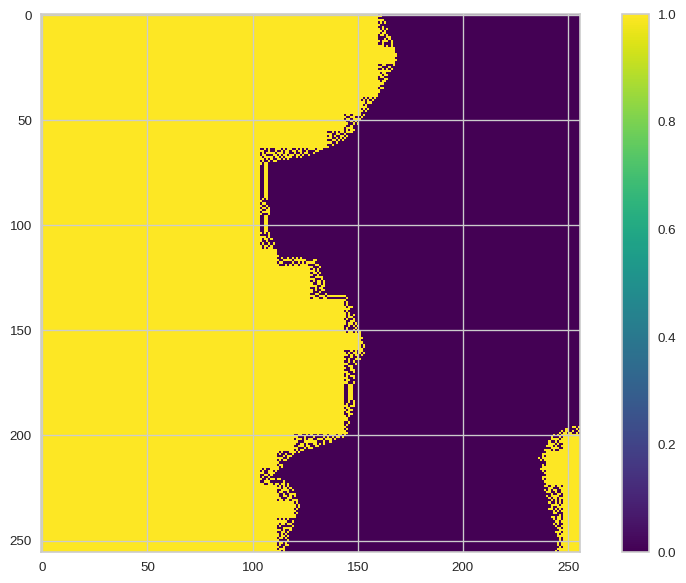

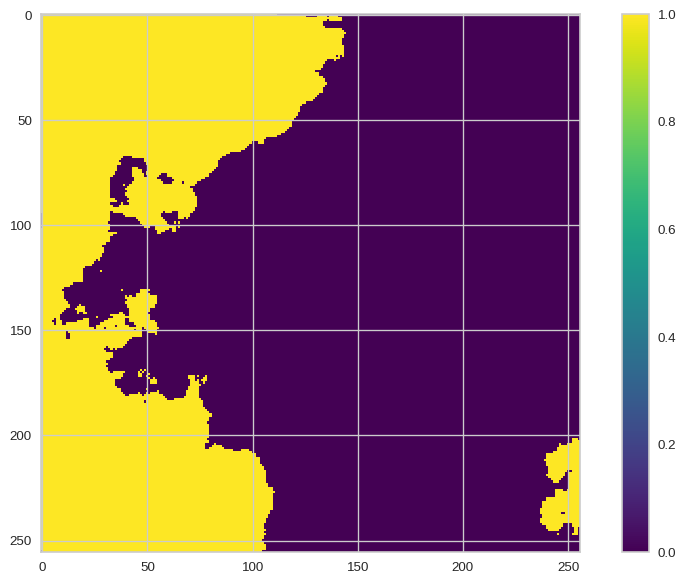

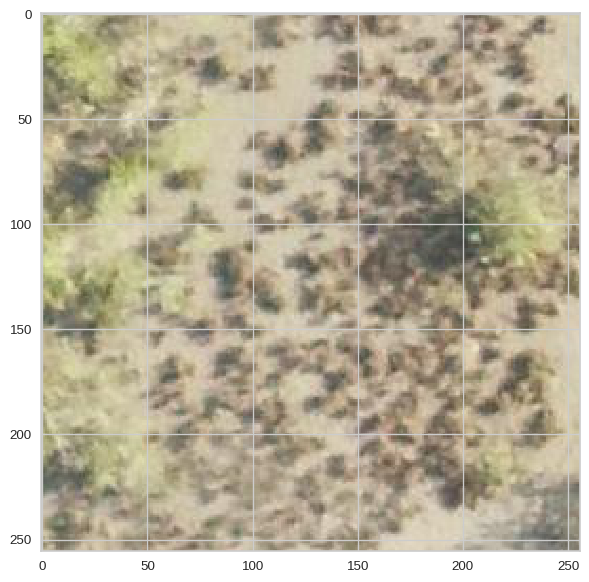

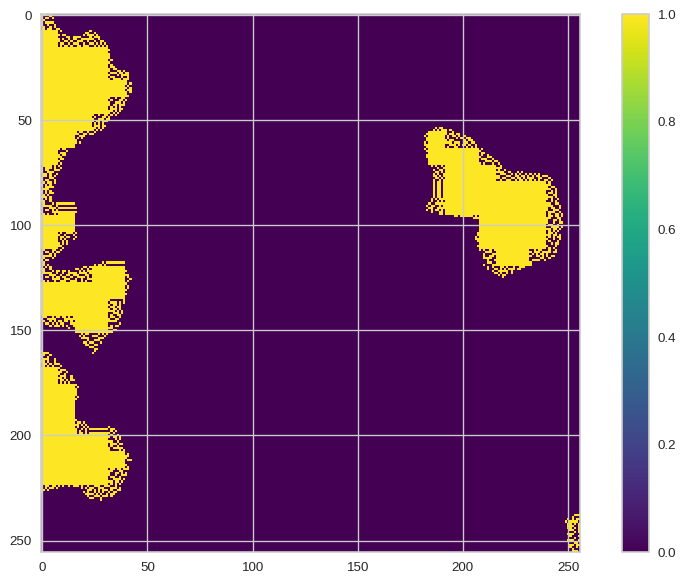

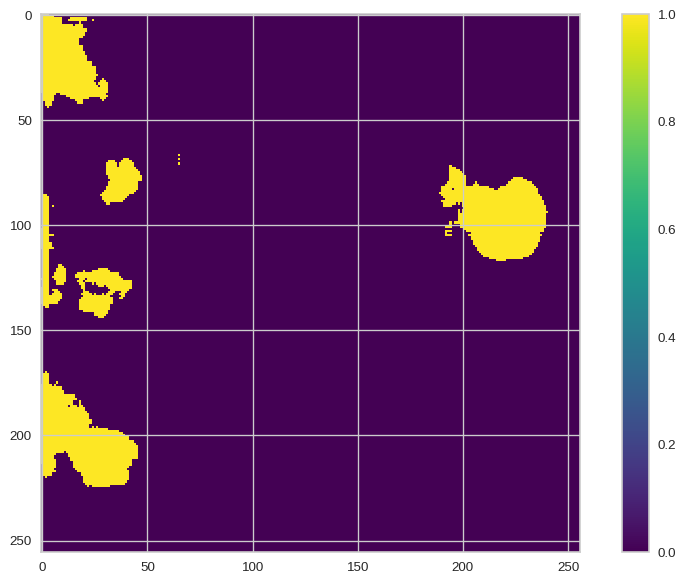

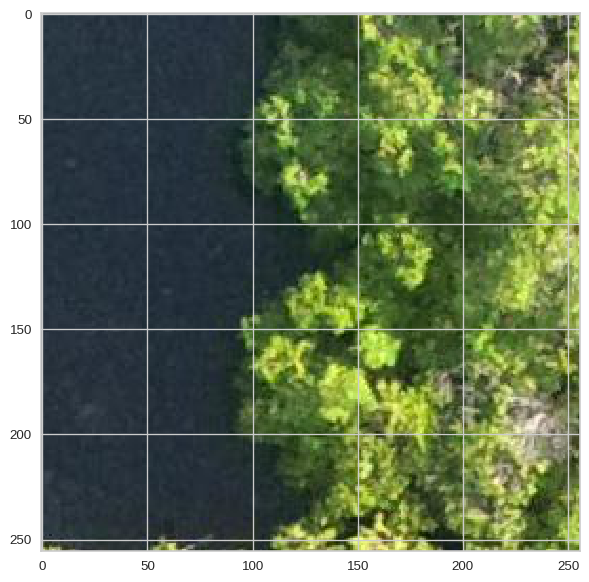

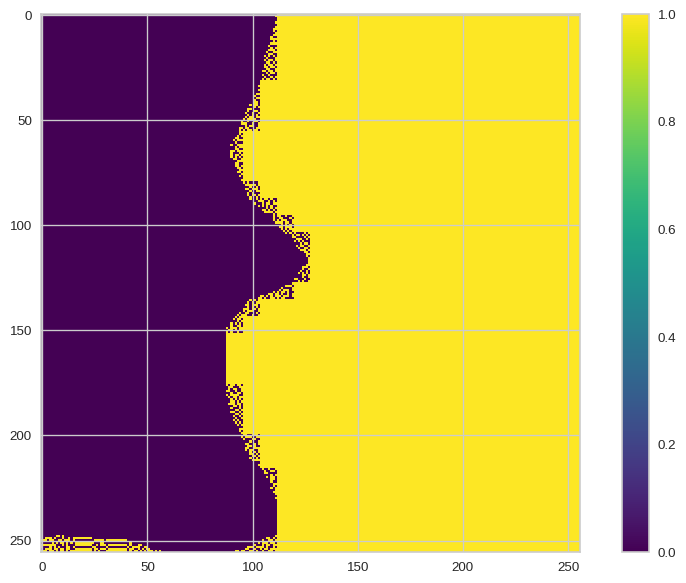

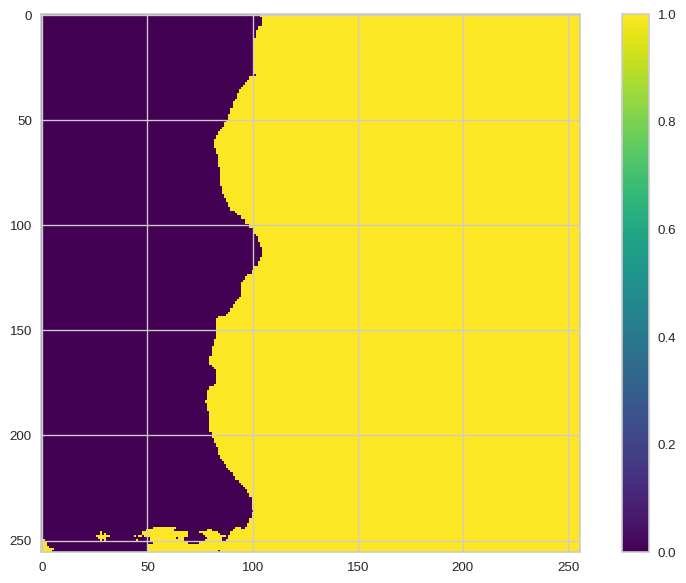

In [ ]:
'''
UNET BASELINE
This uses the limited labelled data and trains a UNET model on this.
'''
unet_baseline_model = UNET_Baseline(x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test)
checkpointer, tensorboard_cb = unet_baseline_model.setup_checkpoint_files()
model_seg_baseline = unet_baseline_model.U_Net_Seg_Baseline(size,img_shape=x_train.shape[1:])
unet_baseline_model.model_summary(model_seg_baseline)
model_seg_baseline = unet_baseline_model.model_train(model_seg_baseline, checkpointer, tensorboard_cb )

#PLOT 4 IMAGES for 256 pixels the index of images to plot - 48,49,59,89 , for 4096 the index of images to plot - 1,4,5,8
visualize_image_paths = [os.path.join(images_root,"image_48.jpg"),os.path.join(images_root,"image_49.jpg"),os.path.join(images_root,"image_59.jpg"),os.path.join(images_root,"image_18.jpg")]
visualize_label_paths = [os.path.join(labels_root,"annotation_48.jpg"),os.path.join(labels_root,"annotation_49.jpg"),os.path.join(labels_root,"annotation_59.jpg"),os.path.join(labels_root,"annotation_18.jpg")]
print("Displaying the predictions for some images... \n",visualize_image_paths)
x,y = get_data(visualize_image_paths,visualize_label_paths,size)
for i in range(4):
  unet_baseline_model.plot_predictions(x, y, model_seg_baseline, img_index=i)


****************************************************************************************************
****************************************************************************************************
RUNNING THE UNET AUTOENCODER MODEL FOR SEMI SUPERVISED SEMANTIC SEGMENTATION.......... 

Unlabelled Train Shape:  (1666, 256, 256, 3)
Unlabelled Validation Shape:  (185, 256, 256, 3)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
_____________________

0it [00:00, ?it/s]


Epoch 00065: val_loss did not improve from 0.08681
Displaying the predictions for some images... 
 ['dataset_256px/training/images/image_48.jpg', 'dataset_256px/training/images/image_49.jpg', 'dataset_256px/training/images/image_59.jpg', 'dataset_256px/training/images/image_18.jpg']


4it [00:30,  7.74s/it]


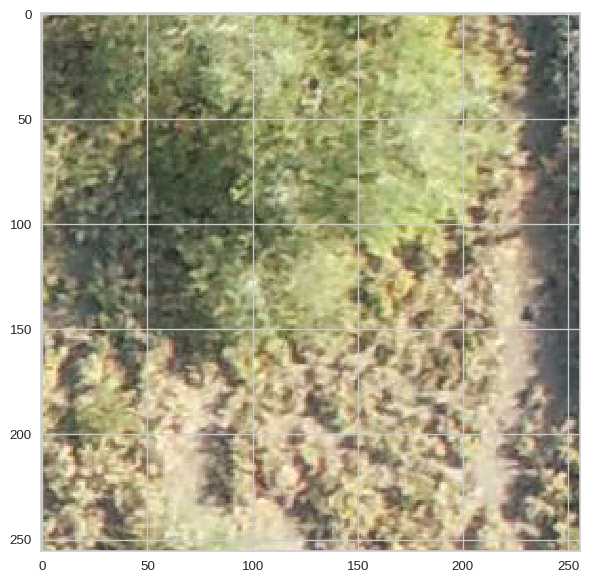

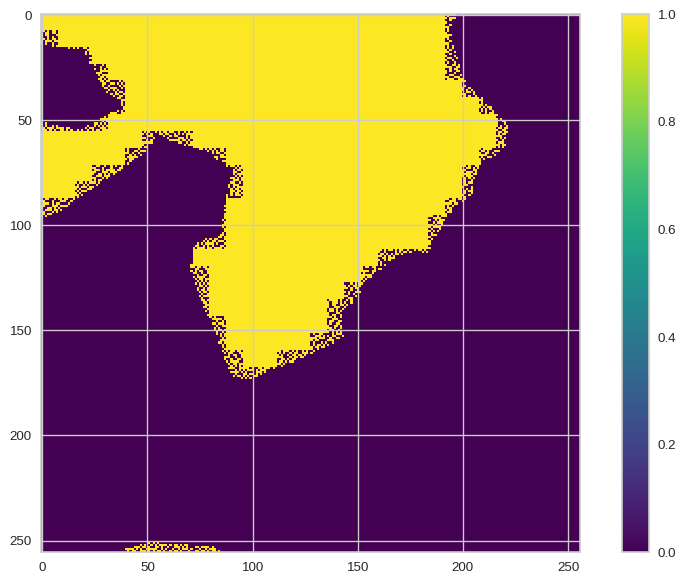

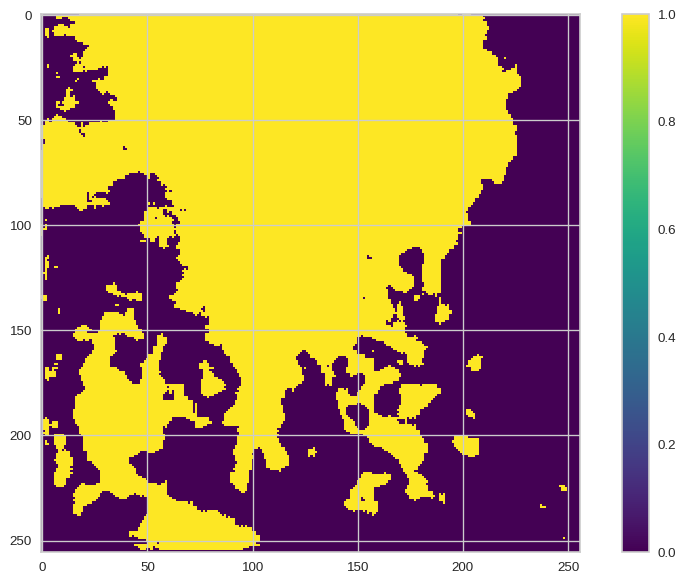

YellowbrickTypeError: ignored

In [ ]:
'''
UNET AUTOENCODER
This first builds an autoencoder with the limited labelled data. The learnt weights are stored and used to pretrained a supervised UNET classifier.
'''
x_unlabelled_train = x_unlabelled[:int(0.9*len(x_unlabelled))]
x_unlabelled_valid = x_unlabelled[int(0.9*len(x_unlabelled))+1:]
unet_autoencoder_model = UNET_Autoencoder(x_train,y_train,x_valid,y_valid,x_unlabelled,x_test,y_test, x_unlabelled_train, x_unlabelled_valid)
save_file_ae, checkpointer, tensorboard_cb = unet_autoencoder_model.setup_files_autoencoder()
model_ae = unet_autoencoder_model.U_Net_AutoEncoder(size,img_shape=x_unlabelled_train.shape[1:])
unet_autoencoder_model.model_summary_ae(model_ae)
model_ae = unet_autoencoder_model.model_train_ae(model_ae, checkpointer, tensorboard_cb)

save_path = 'final_weights_256/{}.h5'.format(save_file_ae)

#save_path = 'weights/{}.h5'.format('autoencoder-full-dstl-model-20180602-181822')
# Pass in the path we saved the weights file too as well as the model
model_segmentation = unet_autoencoder_model.U_Net_Seg_Transfer(model_ae, save_path)

# Printout all the layer names and whether or not they are set to be trained 
for layer in model_segmentation.layers:
    print(layer, layer.trainable)

# Training all the layers works best

for layer in model_segmentation.layers:
        layer.trainable = True

# Printout all the layer names and whether or not they are set to be trained 
for layer in model_segmentation.layers:
    print(layer, layer.trainable)

unet_autoencoder_model.model_summary(model_segmentation)    
checkpointer, tensorboard_cb = unet_autoencoder_model.setup_files()
model_segmentation = unet_autoencoder_model.model_train(model_segmentation, checkpointer, tensorboard_cb)


#PLOT 4 IMAGES for 256 pixels the index of images to plot - 48,49,59,89 , for 4096 the index of images to plot - 1,4,5,8
visualize_image_paths = [os.path.join(images_root,"image_48.jpg"),os.path.join(images_root,"image_49.jpg"),os.path.join(images_root,"image_59.jpg"),os.path.join(images_root,"image_18.jpg")]
visualize_label_paths = [os.path.join(labels_root,"annotation_48.jpg"),os.path.join(labels_root,"annotation_49.jpg"),os.path.join(labels_root,"annotation_59.jpg"),os.path.join(labels_root,"annotation_18.jpg")]
print("Displaying the predictions for some images... \n",visualize_image_paths)
x,y = get_data(visualize_image_paths,visualize_label_paths,size)
for i in range(4):
  unet_autoencoder_model.plot_predictions(x, y, model_segmentation, img_index=i)

In [ ]:
%matplotlib inline
viz = PrecisionRecallCurve(model_segmentation)
viz.fit(x,y)
viz.score(x, y)
viz.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    #return pred_mask[0]
    return pred_mask






In [ ]:
visualize_image_paths = glob.glob('dataset_256px/testing_new/images/*.tif')   #This is random
images_root = 'dataset_256px/testing_new/images'
labels_root = 'dataset_256px/testing_new/images'
visualize_label_paths = [ img.replace(images_root, labels_root).replace('image','image') for img in visualize_image_paths ]

x,y = get_data(visualize_image_paths,visualize_label_paths,size)
print(x.shape)

2316it [00:12, 189.80it/s]


(2316, 256, 256, 3)


In [ ]:

#Predict using whatever model to be tested
PL_FLAG = True
x_shape = x.shape
if PL_FLAG:
  x = np.reshape(x,(x_shape[0]*x_shape[1]*x_shape[2],3))

predicted_masks = classifier.predict(x)

if PL_FLAG:
  predicted_masks = np.reshape(predicted_masks, (x_shape[0],x_shape[1], x_shape[2],1))

In [ ]:
predicted_masks.shape

(2316, 256, 256, 1)

In [ ]:
#Writing the tile by tile classification in the ouput folder
for i in range(len(visualize_image_paths)):
    head, filename = os.path.split(visualize_image_paths[i])
    out = os.path.join('dataset_256px/testing_new/output/',filename ).replace("jpg","tif")
    
    tif.imsave(out, predicted_masks[i, :, :, :] < 0.5)

In [ ]:
#Adding the geodata to the classified tiles and storing it in the out_with_geodata folder
out_dir  = 'dataset_256px/testing_new/output/'
final_out_dir = 'dataset_256px/testing_new/output_with_geodata'
classified_dataset = glob.glob(os.path.join(out_dir, "*.tif"))
for img_file in tqdm(classified_dataset):

  tif_file = img_file.replace("output","images")

  img = 1*np.asarray(Image.open(img_file))
  img = np.expand_dims(img, axis = 2)
  pred_mask = np.array(img).astype('uint8') * 255

  # Reading metadata from .tif
  with rasterio.open(tif_file) as src:
      tif_meta = src.meta
      tif_meta['count'] = 1

  # Writing prediction mask as a .tif using extracted metadata
  mask_file = img_file.replace("output", "output_with_geodata")
  with rasterio.open(mask_file, "w", **tif_meta) as dest:
      # Rasterio needs [bands, width, height]
      pred_mask = np.rollaxis(pred_mask, axis=2)
      dest.write(pred_mask)




  

100%|██████████| 2316/2316 [02:15<00:00, 17.14it/s]


In [ ]:
#Merging the tiles to create an ortho
print("Merging tiles (to create mask ortho)...")
call = "gdal_merge.py -o " + "dataset_256px/testing_new/ortho_mask.tif " + " " + final_out_dir + "/*"
print(call)
subprocess.call(call, shell=True)


Merging tiles (to create mask ortho)...
gdal_merge.py -o dataset_256px/testing_new/ortho_mask.tif  dataset_256px/testing_new/output_with_geodata/*


0